In [1]:
import wplus_utils
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import ptp_utils
import os

In [2]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False, steps_offset=1)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("/data/CompVis/stable-diffusion-v1-4", local_files_only=True, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [3]:
image_path = "./example_images/a black bear climb a tree in rain.png"
prompt = "a black bear climb a tree in rain"

matrix_inversion = wplus_utils.MatrixInversion(ldm_stable,inner_steps_num=None,lambda_norm=0e-7,use_freq=False,use_attn_loss=False) #derain 1e-7
(image_gt, image_enc), x_t, uncond_embeddings, w_matrices = matrix_inversion.invert(image_path, prompt, offsets=(0,0,0,0), num_inner_steps=10, verbose=True, learning_rate=1e1)
# w_modify_end(w_matrices,0.5)

DDIM inversion...
Guidance Matrix optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

   step_i: 0 loss: 1.7797436157707125e-05
   step_i: 1 loss: 2.2560581783181988e-05
   step_i: 2 loss: 3.034464316442609e-05
   step_i: 3 loss: 3.258124343119562e-05
   step_i: 4 loss: 3.52154893334955e-05
   step_i: 5 loss: 4.038464612676762e-05
   step_i: 6 loss: 4.6204098907765e-05
   step_i: 7 loss: 5.154183600097895e-05
   step_i: 8 loss: 5.43276037205942e-05
   step_i: 9 loss: 5.239639722276479e-05
   step_i: 10 loss: 4.862163768848404e-05
   step_i: 11 loss: 4.89903031848371e-05
   step_i: 12 loss: 4.908863047603518e-05
   step_i: 13 loss: 4.927836198476143e-05
   step_i: 14 loss: 5.002306352253072e-05
   step_i: 15 loss: 4.96106076752767e-05
   step_i: 16 loss: 4.868803080171347e-05
   step_i: 17 loss: 6.801995914429426e-05
   step_i: 18 loss: 8.2834463682957e-05
   step_i: 19 loss: 7.552147144451737e-05
   step_i: 20 loss: 7.730608194833621e-05
   step_i: 21 loss: 7.832875417079777e-05
   step_i: 22 loss: 7.405231008306146e-05
   step_i: 23 loss: 7.011597335804254e-05
   step_

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, w+ reconstruction, w+ derain


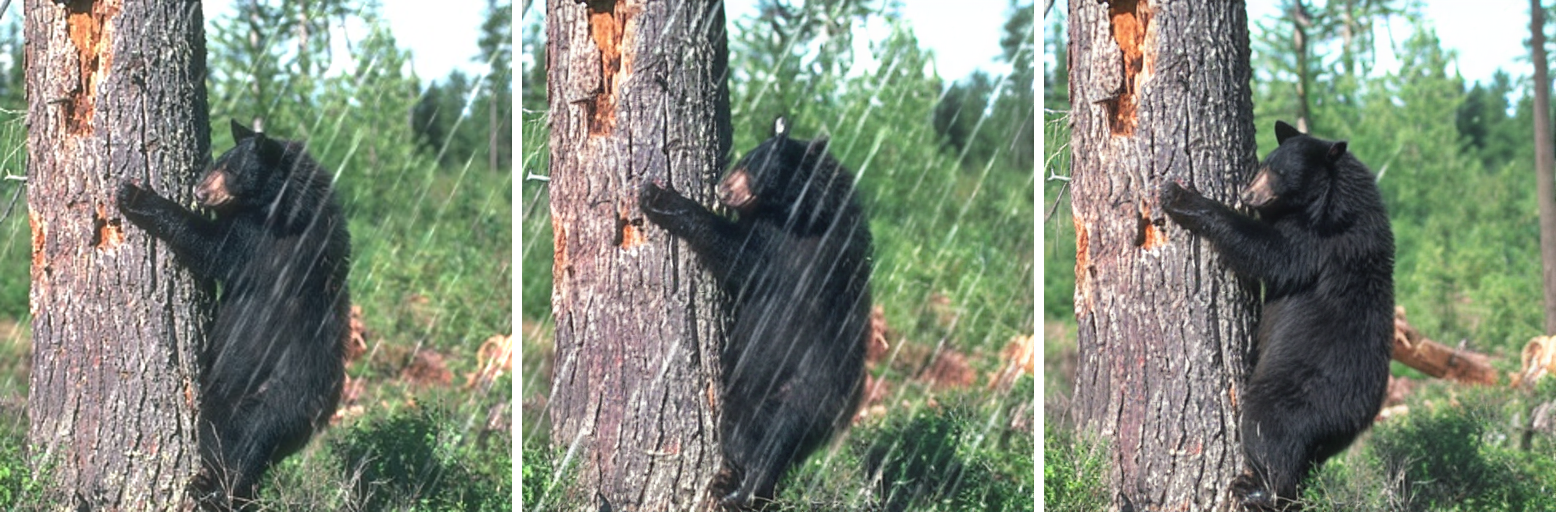

PSNR：21.730865434061908，SSIM：0.6842171989328937，MSE：436.5096181233724


In [4]:
prompts = [prompt]
cross_replace_steps = 0.0
self_replace_steps = 0.0
tao = 0.9
negative_prompt = "rain"

controller = wplus_utils.WplusAttentionStore(cross_replace_steps=cross_replace_steps,self_replace_steps=self_replace_steps)
image_derain, x_t = wplus_utils.run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=None, optimize_matrices=w_matrices, negative_prompt=negative_prompt, verbose=False, tao=tao)
# wplus_utils.show_cross_attention(controller,16,["up", "down"],prompts,ldm_stable,0,negative_prompt=negative_prompt)
controller = wplus_utils.AttentionStore()
image_inv, x_t = wplus_utils.run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=None, optimize_matrices=w_matrices, verbose=False)
# wplus_utils.show_cross_attention(controller,16,["up", "down"],prompts,ldm_stable,0)
# show_self_attention_comp(controller,16,["up", "down"],10,0)
print("showing from left to right: the ground truth image, w+ reconstruction, w+ derain")
ptp_utils.view_images([image_gt, image_inv[0], image_derain[0]])

p = wplus_utils.compare_psnr(image_gt, image_inv[0])
s = wplus_utils.compare_ssim(image_gt, image_inv[0], multichannel=True, channel_axis=2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
m = wplus_utils.compare_mse(image_gt, image_inv[0])
 
print('PSNR：{}，SSIM：{}，MSE：{}'.format(p, s, m))

In [7]:
directory_path = "/home/liutao/workspace/deraindiffusion/example_images/loop_test/"
save_path = "/home/liutao/workspace/deraindiffusion/example_images/result/"
files = os.listdir(directory_path)
matrix_inversion = wplus_utils.MatrixInversion(ldm_stable,inner_steps_num=None,lambda_norm=0e-7)
cross_replace_steps = 0.0
self_replace_steps = 0.0
tao = 1.0
negative_prompt = "in rain"
image_list = []

for file in files:
    if file.lower().endswith(".jpg"):
        image_path = directory_path + file
        prompt = os.path.splitext(file)[0]
        print(prompt)
        (image_gt, image_enc), x_t, uncond_embeddings, w_matrices = matrix_inversion.invert(image_path, prompt, offsets=(0,0,0,0), num_inner_steps=10, verbose=True, learning_rate=1e1)
        
        prompts = [prompt]
        controller = wplus_utils.WplusAttentionStore(cross_replace_steps=cross_replace_steps,self_replace_steps=self_replace_steps)
        image_derain, x_t = wplus_utils.run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=None, optimize_matrices=w_matrices, negative_prompt=negative_prompt, verbose=False, tao=tao)
        controller = wplus_utils.AttentionStore()
        image_inv, x_t = wplus_utils.run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=None, optimize_matrices=w_matrices, verbose=False)
    save_name = prompt+".jpg"
    ptp_utils.view_images([image_gt, image_inv[0], image_derain[0]]).save(os.path.join(save_path+save_name))


An ancient Egyptian statue building in the rain
DDIM inversion...
Guidance Matrix optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

   step_i: 0 loss: 3.538322744134348e-06
   step_i: 1 loss: 8.498114766553044e-06
   step_i: 2 loss: 1.3926977771916427e-05
   step_i: 3 loss: 1.909321508719586e-05
   step_i: 4 loss: 2.396995114395395e-05
   step_i: 5 loss: 2.8956059395568445e-05
   step_i: 6 loss: 3.3591946703381836e-05
   step_i: 7 loss: 3.840787394437939e-05
   step_i: 8 loss: 4.31333901360631e-05
   step_i: 9 loss: 4.7666322643635795e-05
   step_i: 10 loss: 5.228465306572616e-05
   step_i: 11 loss: 5.7279794418718666e-05
   step_i: 12 loss: 6.215162284206599e-05
   step_i: 13 loss: 6.603149813599885e-05
   step_i: 14 loss: 6.675063195871189e-05
   step_i: 15 loss: 6.4087551436387e-05
   step_i: 16 loss: 5.7111697969958186e-05
   step_i: 17 loss: 5.2084142225794494e-05
   step_i: 18 loss: 5.6556200433988124e-05
   step_i: 19 loss: 7.238257967401296e-05
   step_i: 20 loss: 7.753085810691118e-05
   step_i: 21 loss: 6.881030276417732e-05
   step_i: 22 loss: 6.657405901933089e-05
   step_i: 23 loss: 6.181663775350899e-

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]